# Imports

In [ ]:
!pip uninstall deepdowmine -y
!pip install git+https://github.com/dsman1823/deepdowmine.git

In [1]:
import numpy as np
import pandas as pd
import torch

from matplotlib import pyplot as plt
from deepdowmine.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale, SeqRigidDataLoader, WeeklyRigidDataLoader
from deepdowmine.losses import MeanReturns, SharpeRatio, MaximumDrawdown, StandardDeviation
from deepdowmine.nn import DenseNetFullOpti2, DenseNetMinVar2, RnnNetMinVar2, RnnNetMinVar, DenseNetFullOpti2, RnnNetFullOpti2, ConvNetFullOpti2
from deepdowmine.experiments import Run
from deepdowmine.callbacks import EarlyStoppingCallback
from deepdowmine.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap




# Setup

In [46]:
np.random.seed(5)
returns = pd.read_csv('train_data_2.csv', index_col = 0).to_numpy()[1:]

In [47]:
len(returns)

4015

In [48]:
n_timesteps, n_assets = len(returns), 5#11**4, 450

#returns = np.random.normal(0, .2, size = (n_timesteps, n_assets))

lookback, gap, horizon = 50, 0, 5# 40, 0, 5   loss=-0.09645, test_loss=-0.08003]
n_samples = n_timesteps - lookback - horizon - gap + 1

indices = np.arange(n_samples)
split_ix = int(n_samples * 0.8)
indices_train = indices[:split_ix]
indices_test = indices[split_ix:]


# print('Train range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],
#                                                      indices_test[0], indices_test[-1]))

In [49]:
def transform_returns_to_Xy_tensors(returns, lookback, n_timesteps, horizon, gap):
    X_list, y_list = [], []

    for i in range(lookback, n_timesteps - horizon - gap + 1):
        X_list.append(returns[i - lookback: i, :])
        y_list.append(returns[i + gap: i + gap + horizon, :])

    X = np.stack(X_list, axis=0)[:, None, ...]
    y = np.stack(y_list, axis=0)[:, None, ...]

    return X, y

In [50]:

#returns = np.random.normal(0, .2, size = (n_timesteps, n_assets))

# X_list, y_list = [], []

# for i in range(lookback, n_timesteps - horizon - gap + 1):
#     X_list.append(returns[i - lookback: i, :])
#     y_list.append(returns[i + gap: i + gap + horizon, :])

# X = np.stack(X_list, axis=0)[:, None, ...]
# y = np.stack(y_list, axis=0)[:, None, ...]
X, y = transform_returns_to_Xy_tensors(returns, lookback, n_timesteps, horizon, gap)
#print('X: {}, y: {}'.format(X.shape, y.shape))

# means, stds = prepare_standard_scaler(X, indices=indices_train)
# print('mean: {}, std: {}'.format(means, stds))

dataset = InRAMDataset(X, y)
#, transform=Scale(means, stds))

torch.manual_seed(32)

dataloader_train = RigidDataLoader(dataset,
                                   indices=indices_train,
                                   batch_size=32)

dataloader_test = SeqRigidDataLoader(dataset,
                                  indices=indices_test,
                                  batch_size=32)

dataloader_train_for_retrain = RigidDataLoader(dataset,
                                  indices=indices_test,
                                  batch_size=32)
dataloader_test_for_retrain = SeqRigidDataLoader(dataset,
                                   indices=indices_train,
                                   batch_size=32)


# Network setup

In [51]:
network = ConvNetFullOpti2(1,  50, 5, .15, 1)

In [52]:

print(network)
network = network.train()
loss = SharpeRatio()
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={
              'test': dataloader_test,
              'train': dataloader_train
              },
          optimizer=torch.optim.Adam(network.parameters(), amsgrad=True, lr=0.001),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=10)]) #15 # patience controlls amount offffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffrfvd

ConvNetFullOpti2(
  (norm_layer): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_layer): Dropout(p=0.15, inplace=False)
  (conv_layer): Conv2d(1, 2, kernel_size=(3, 1), stride=(2, 1))
  (covariance_layer): CovarianceMatrix()
  (linear): Linear(in_features=120, out_features=5, bias=True)
  (linear_cov): Linear(in_features=120, out_features=100, bias=True)
  (portfolio_layer): ThesisMarkowitzFullOpti(
    (cvxpylayer): CvxpyLayer()
  )
)


# Train start

In [45]:
history = run.launch(70)
torch.save(network.state_dict(), 'network.pth')

## Retrain the model on validation set with limited amount of epochs, and limited learning rate

In [ ]:
network_retrained = ConvNetFullOpti2(1,  50, 5, .15, 1)

network_retrained.load_state_dict(network.state_dict())

##!!!!!!!!!!!!!!!!!!!!!!!!
# state_dict = torch.load('min_var_1.pth')
# network_retrained.load_state_dict(state_dict)
# ####


print(network_retrained)
network_retrained = network_retrained.train()
loss = SharpeRatio()
run = Run(network_retrained,
          loss,
          dataloader_train_for_retrain,
          val_dataloaders={
              'train': dataloader_train_for_retrain,
              'test': dataloader_test_for_retrain
              },
          optimizer=torch.optim.Adam(network_retrained.parameters(), amsgrad=True, lr=0.0005),
)

In [ ]:
history_retrain = run.launch(60)
torch.save(network_retrained.state_dict(), 'network_retrained.pth')

In [ ]:
network.gamma

# Check model perfomance

In [ ]:
  # network = LstmNetMinVar(5)
  # network.load_state_dict(torch.load(fr'network_2.pth'))

In [17]:
per_epoch_results = history.metrics.groupby(['dataloader', 'metric', 'model', 'epoch'])['value']

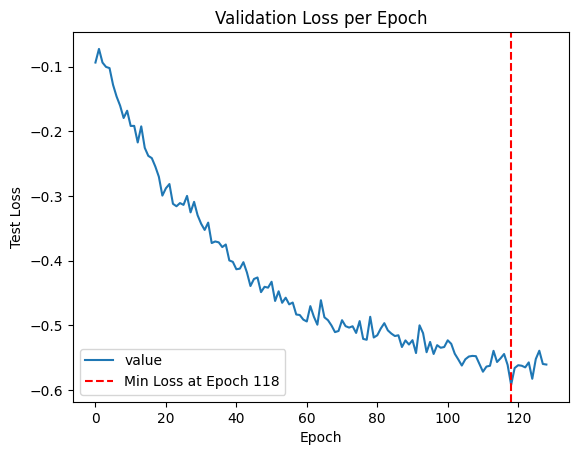

In [18]:
mean_test_loss = per_epoch_results.mean()['test']['loss']['network'] # tmp

# Plotting the mean test loss per epoch
mean_test_loss.plot()

# Finding the epoch with the minimum test loss
min_loss_epoch = mean_test_loss.idxmin()
min_loss_value = mean_test_loss.min()

# Adding a red vertical line at the epoch with minimum test loss
plt.axvline(x=min_loss_epoch, color='r', linestyle='--', label=f'Min Loss at Epoch {min_loss_epoch}')

# Adding some labels and title for clarity
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Validation Loss per Epoch')
plt.legend()

# Show the plot
plt.show()

In [19]:
per_epoch_results.mean()['test']['loss']['network'].mean()

-0.43268597

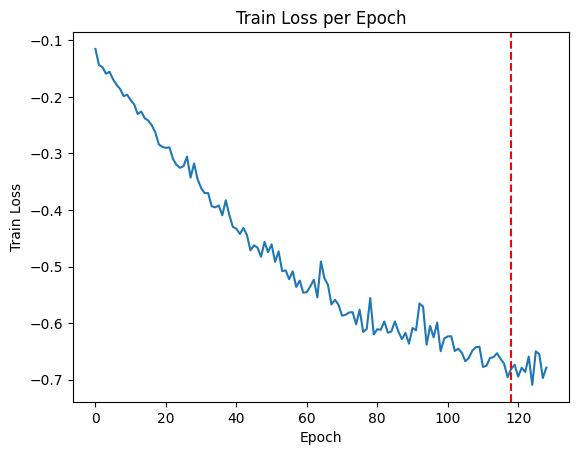

In [20]:
mean_train_loss = per_epoch_results.mean()['train']['loss']['network']

# Plotting the mean test loss per epoch
mean_train_loss.plot()



# Adding some labels and title for clarity
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss per Epoch')
plt.axvline(x=min_loss_epoch, color='r', linestyle='--', label=f'The best model {min_loss_epoch}')

# Show the plot
plt.show()

In [ ]:
network.tmp['output'].shape

# Compute validation factor

In [42]:
X_tensor = torch.tensor(X[indices_test], dtype=torch.float32)
y_tensor = torch.tensor(y[indices_test], dtype=torch.float32)

In [43]:
weights = network(X_tensor)
ewp = weights.new_full(weights.shape, 0.2)

In [44]:
loss(weights, y_tensor).mean()  /  loss(ewp, y_tensor).mean()

tensor(1.1455, grad_fn=<DivBackward0>)